# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [13]:
import numpy as np
import doctest
import matplotlib.pyplot as plt
import pandas as pd

## Data Generation

Income: [  80.00994467   80.09733417   80.12101885 ... 2065.87487826 2138.4934517
 4009.12770394]
Housing Distance: [1.74105767e-03 3.18992637e-03 7.82843317e-03 ... 6.39465559e+01
 6.66000716e+01 7.22130022e+01]


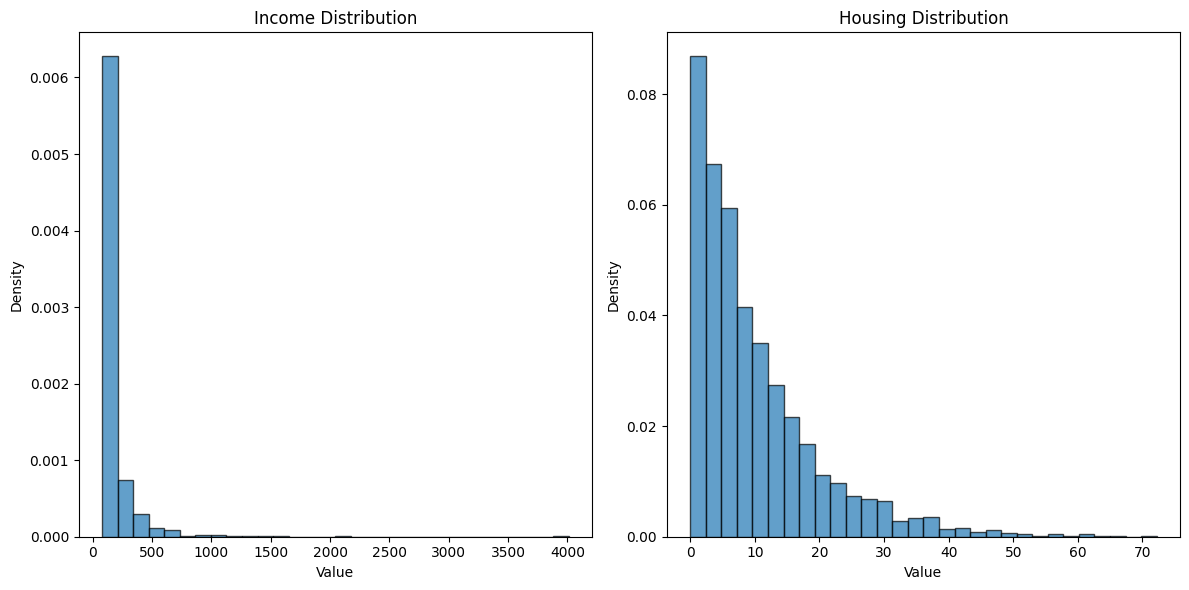

In [25]:
def gen_data(n, y_min, alpha, mu, c, seed=1):

  # Validate parameters
    if y_min <= c:
        raise ValueError
    if alpha <= 1:
        raise ValueError
    if mu <= 0:
        raise ValueError

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)
    d = np.sort(d)
    return y, d


# Generate samples for visualization
n = 2000
y_min = 80
alpha = 1.75
mu = 10
c = 50
seed = 1

y_samples, d_samples = gen_data(n, y_min, alpha, mu, c, 1)
print(f'Income: {y_samples}')
print(f'Housing Distance: {d_samples}')

# PLOT DISTRIBUTIONS

plt.figure(figsize=(12, 6))

# INCOME
plt.subplot(1, 2, 1)
plt.hist(y_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Income Distribution")
plt.xlabel("Value")
plt.ylabel("Density")


# HOUSING
plt.subplot(1, 2, 2)
plt.hist(d_samples, bins=30, density=True, alpha=0.7, edgecolor="black")
plt.title("Housing Distribution")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Visualization and Statistics

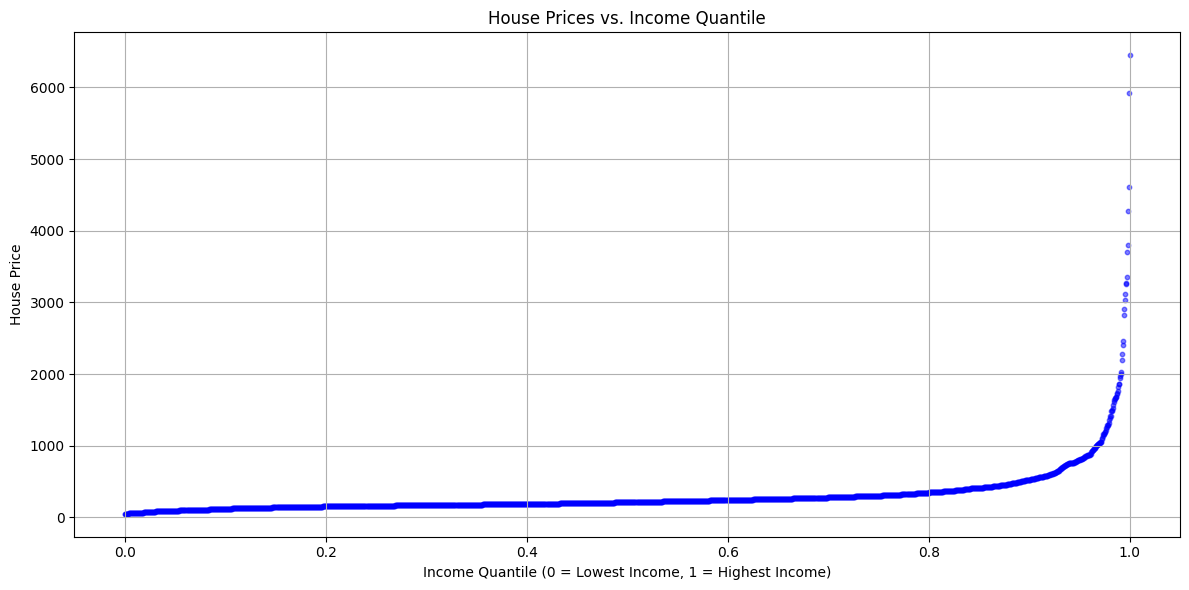

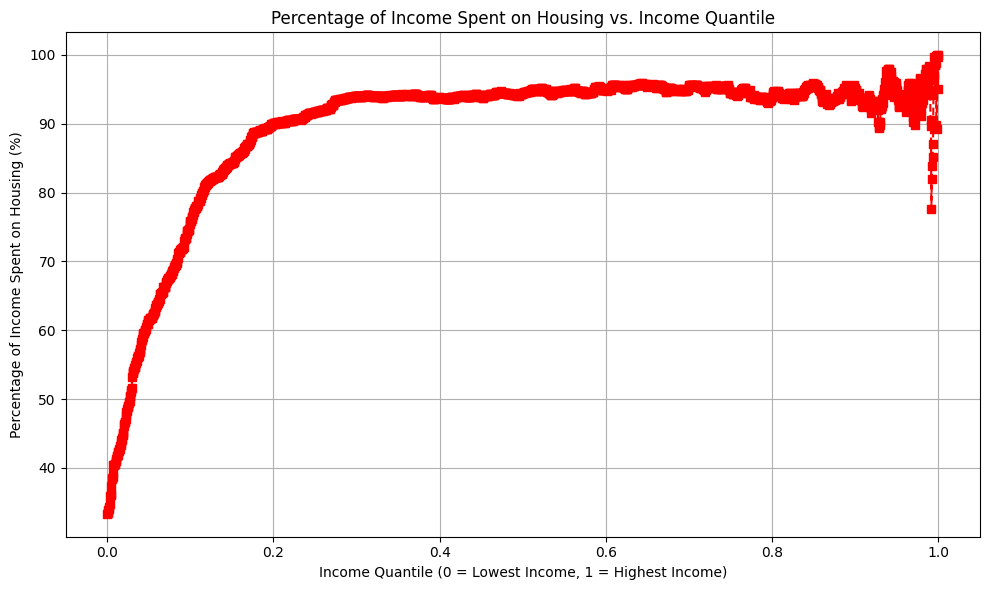

{'average': np.float64(309.73867035719707), 'median': np.float64(211.61180768898623), 'Q1': np.float64(161.63736132652093), 'Q3': np.float64(303.1840176415295), 'IQR': np.float64(141.5466563150086)}


In [ ]:
def compute_statistics(prices):
    average = np.mean(prices)
    median = np.median(prices)
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1

    statistics = {
        'average': average,
        'median': median,
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR': IQR
    }

    return statistics


def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)

    plt.figure(figsize=(12, 6))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_house_prices(y, prices)
#plot_percentage_income_spent(y, prices)
#print(compute_statistics(prices))

## 2a

In [8]:
def equilibrium_price_recursive(n, c, y, d, j):

    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")

    if j == 0:
        return c  # Base case: first house price is equal to c

    theta_j = np.exp(-(d[j] - d[j - 1]))
    # Recursive call for the previous house (j-1)
    previous_price = equilibrium_price_recursive(n, c, y, d, j - 1)
    equilibrium_price = theta_j * previous_price + (1 - theta_j) * y[j]
    return equilibrium_price

def calc_all_prices(n, c, y, d):
    prices = []
    for j in range(n):
        prices.append(equilibrium_price_recursive(n, c, y, d, j))
    return np.array(prices)


## 4a

### i, ii, iii

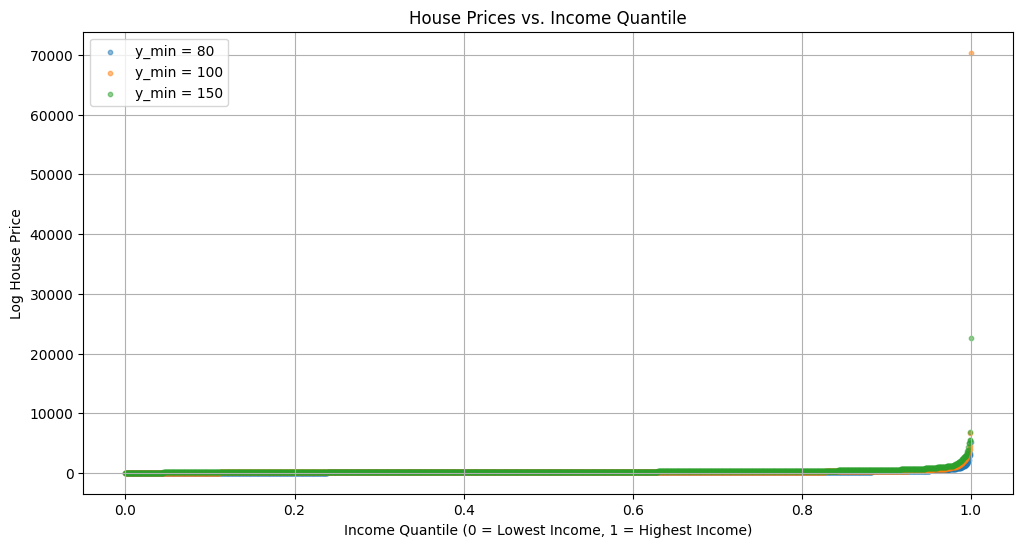

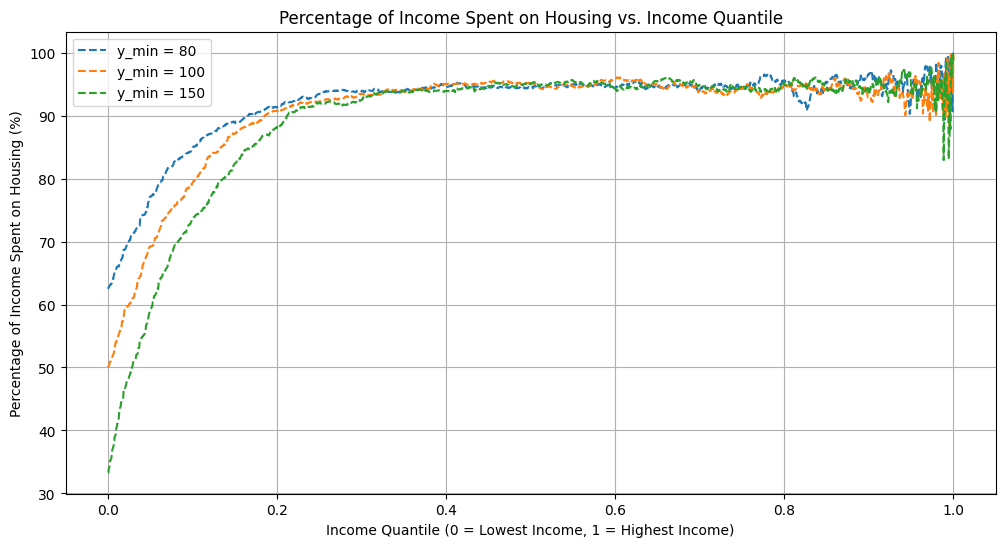

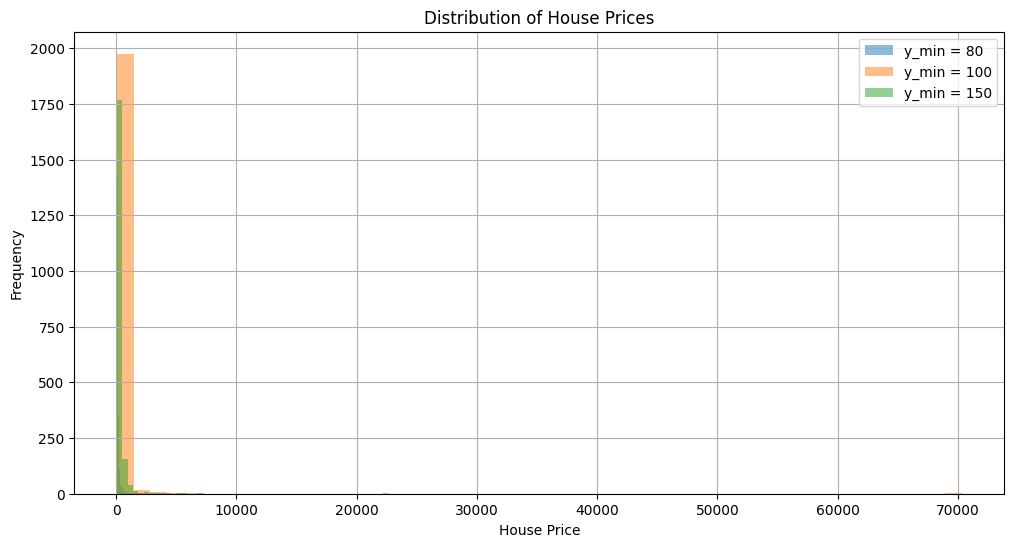

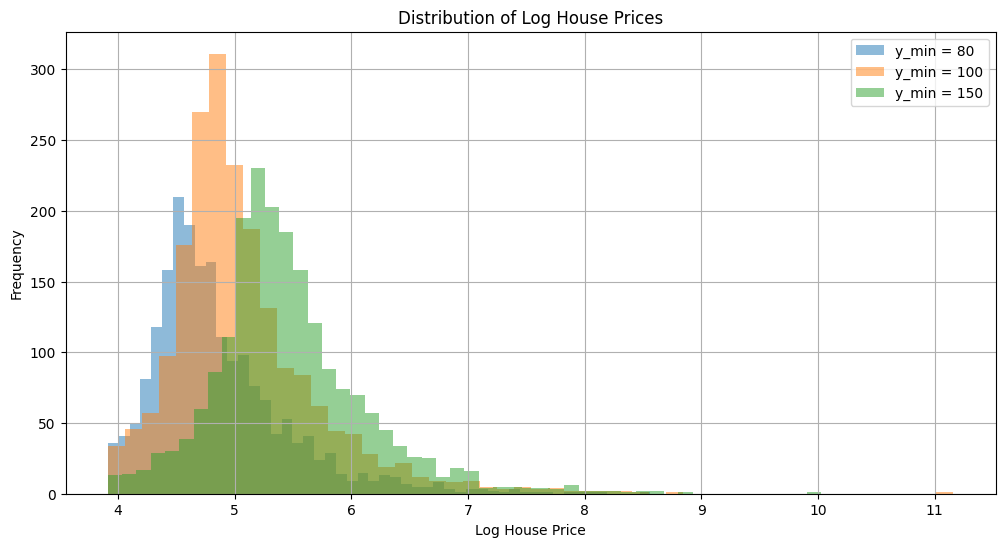

"\n# Third plot: House Prices vs Log Income\nplt.figure(figsize=(12, 6))\nfor i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):\n    plt.scatter(np.log(y), prices, s=10, alpha=0.5, label=f'y_min = {y_min}')\n\nplt.xlabel('Log Income')\nplt.ylabel('House Price')\nplt.title('House Prices vs. Log Income')\nplt.grid(True)\nplt.legend()\nplt.show()"

In [28]:
n = 2000
y_min_list = [80, 100, 150]
alpha = 1.75
mu = 10
c = 50
seed = 1
# Initialize lists to collect statistics and data
stats_list = []
all_y = []  # Store income data
all_prices = []  # Store price data

# Iterate over each y_min value
for y_min in y_min_list:
    # Generate data
    y, d = gen_data(n, y_min, alpha, mu, c)
    
    # Calculate equilibrium prices
    prices = calc_all_prices(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['y_min'] = y_min  
    stats_list.append(stats)
    
    # Test base case
    base_case_price = prices[0]  # This is the price of house j=1
    if base_case_price == c:
        base_case_result = f"Base Case check passed: {base_case_price}"
    else:
        base_case_result = f"Base Case check failed: {base_case_price}"

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Log House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.hist(prices, bins=50, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.hist(np.log(prices), bins=50, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('Log House Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log House Prices')
plt.grid(True)
plt.legend()
plt.show()

"""
# Third plot: House Prices vs Log Income
plt.figure(figsize=(12, 6))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    plt.scatter(np.log(y), prices, s=10, alpha=0.5, label=f'y_min = {y_min}')

plt.xlabel('Log Income')
plt.ylabel('House Price')
plt.title('House Prices vs. Log Income')
plt.grid(True)
plt.legend()
plt.show()"""

## 2b

In [ ]:
def equilibrium_price_memoized(n, c, y, d, j, memo=None):
    # Initialize memo array if not provided
    if memo is None:
        memo = np.full(n, np.nan)
    
    # Check if value is out of bounds
    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")
    
    # Check if value has been memoized
    if not np.isnan(memo[j]):
        return memo[j]
    
    # Base case: first house
    if j == 0:
        memo[j] = c
        return memo[j]
    
    # Calculate theta_j
    theta_j = np.exp(-(d[j] - d[j - 1]))
    
    # Recursive call for previous house with memoization
    previous_price = equilibrium_price_memoized(n, c, y, d, j - 1, memo)
    
    # Calculate and memoize the equilibrium price
    memo[j] = theta_j * previous_price + (1 - theta_j) * y[j]
    return memo[j]

def calc_all_prices_memoized(n, c, y, d):
    memo = np.full(n, np.nan)
    prices = []
    for j in range(n):
        prices.append(equilibrium_price_memoized(n, c, y, d, j, memo))
    return np.array(prices)


## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [ ]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

**********************************************************************
File "__main__", line 25, in __main__.equilibrium_price_memoized
Failed example:
    abs(price1 - price2) < 1e-10
Expected:
    True
Got:
    np.True_
**********************************************************************
1 items had failures:
   1 of   9 in __main__.equilibrium_price_memoized
***Test Failed*** 1 failures.
Rats!
